# GoogLeNet CNN Reproduction
This notebook trains a reproduction of the complex GoogLeNet model.

## Prerequisites

- Install `tensorflow` or if running on a GPU, `tensorflow[and-cuda]`.
- Install `matplotlib`.

Configuring Tensorflow to run on a GPU is not trivial, especially in Windows. To run the latest version of Tensorlow on a GPU, it must be run in [WSL](https://learn.microsoft.com/en-us/windows/wsl/about). [This blog](https://medium.com/@ali.abulhawa/installing-tensorflow-2-16-gpu-on-windows-wsl2-df73ac3446c9) has excellent instructions on configuring a GPU for Tensorflow in WSL.

Now that Tensorflow can detect your GPU in WSL, you need to be able to run this notebook in Jupyter Lab. Follow [this blog](https://towardsdatascience.com/configuring-jupyter-notebook-in-windows-subsystem-linux-wsl2-c757893e9d69) to accomplish that feat.


In [1]:
import tensorflow as tf
import os
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

2024-10-10 14:47:04.367772: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 14:47:04.378484: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 14:47:04.381728: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-10 14:47:04.389729: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-10 14:47:05.026649: W tensorflow/compiler/tf2

## Ingesting the input images

### Prepare the ImageNet images
In the same directory as this notebook, you will find a file named `imagenet_224.zip`. This zip file contains the ImageNet images used for training the CNN.
Unzip the files to a folder named `imagenet_224`. The unzipped files will have the following structure:

```
imagenet_224
----airplane
----automobile
----...
----ship
----truck
``` 
If the folder structure doesn't match this, then you will get an error!

In [2]:
IMAGE_DIR = os.path.join(os.getcwd(), "imagenet_224")

if not os.path.exists(IMAGE_DIR):
    raise RuntimeError(
        f"{IMAGE_DIR} not found. You need to download the ImageNet dataset and unzip it into a folder called imagenet_224")

# You can adjust the batch size depending on the compute resources
BATCH_SIZE = 16

IMG_HEIGHT = 224
IMG_WIDTH = 224
TARGET_SIZE = (IMG_WIDTH, IMG_HEIGHT)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    IMAGE_DIR,           
    validation_split=0.2,     
    subset="training",          
    seed=111,                    
    image_size=TARGET_SIZE,      
    batch_size=BATCH_SIZE              
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    IMAGE_DIR,          
    validation_split=0.2,       
    subset="validation",        
    seed=111,                    
    image_size=TARGET_SIZE,     
    batch_size=BATCH_SIZE              
)

Found 13738 files belonging to 10 classes.
Using 10991 files for training.


I0000 00:00:1728596831.647791   20185 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728596831.664199   20185 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728596831.664268   20185 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728596831.666506   20185 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728596831.666541   20185 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Found 13738 files belonging to 10 classes.
Using 2747 files for validation.


## Performance enhancements
Apply augmentation and prefetching to improve training performance.

In [3]:
augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

# Apply the augmentation only on the training dataset
train_dataset = train_dataset.map(lambda x, y: (augmentation(x, training=True), y))

# Prefetch the datasets for performance improvement
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Build the CNN

In [4]:
# There are 10 image classes.
NUM_CLASSES = 10

# Specify a lower learning late because of the small data set.
LEARNING_RATE = 0.0001

def inception_layer(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    """
    Creates an Inception layer that applies multiple convolutions and pooling operations in parallel and concatenates the results.

    The Inception layer performs the following steps in parallel:
    1. A 1x1 convolution with 'filters_1x1' filters.
    2. A 1x1 convolution followed by a 3x3 convolution, where 'filters_3x3_reduce' controls the number of filters in the initial 1x1 convolution, 
       and 'filters_3x3' specifies the number of filters for the 3x3 convolution.
    3. A 1x1 convolution followed by a 5x5 convolution, where 'filters_5x5_reduce' controls the number of filters in the initial 1x1 convolution,
       and 'filters_5x5' specifies the number of filters for the 5x5 convolution.
    4. A 3x3 max pooling operation followed by a 1x1 convolution with 'filters_pool_proj' filters.

    Finally, the outputs of all these parallel operations are concatenated along the channel axis to form the final output.

    Args:
        x (Tensor): Input tensor to the Inception layer.
        filters_1x1 (int): Number of filters for the 1x1 convolution path.
        filters_3x3_reduce (int): Number of filters for the 1x1 convolution before the 3x3 convolution.
        filters_3x3 (int): Number of filters for the 3x3 convolution.
        filters_5x5_reduce (int): Number of filters for the 1x1 convolution before the 5x5 convolution.
        filters_5x5 (int): Number of filters for the 5x5 convolution.
        filters_pool_proj (int): Number of filters for the 1x1 convolution after the max pooling.

    Returns:
        Tensor: Output tensor resulting from concatenating the filters' outputs.
    """
    conv_1x1 = layers.Conv2D(filters_1x1, (1, 1), padding="same", activation="relu")(x)
    
    conv_3x3 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding="same", activation="relu")(x)
    conv_3x3 = layers.Conv2D(filters_3x3, (3, 3), padding="same", activation="relu")(conv_3x3)
    
    conv_5x5 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding="same", activation="relu")(x)
    conv_5x5 = layers.Conv2D(filters_5x5, (5, 5), padding="same", activation="relu")(conv_5x5)
    
    max_pool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding="same")(x)
    max_pool = layers.Conv2D(filters_pool_proj, (1, 1), padding="same", activation="relu")(max_pool)
    
    output = layers.concatenate([conv_1x1, conv_3x3, conv_5x5, max_pool], axis=-1)
    
    return output

# Define the full model
def googlenet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES):
    """
    Builds a GoogLeNet Inception model.

    The model consists of the following components:
    1. Initial convolution and max-pooling layers.
    2. Two main convolutional blocks, each followed by max-pooling layers.
    3. Multiple Inception layers that apply parallel convolutional and pooling operations,
       followed by max-pooling layers between certain inception layers.
    4. Global Average Pooling.
    5. Dropout to prevent overfitting.
    6. A final fully connected layer with a softmax activation function.

    Args:
        input_shape (tuple): Shape of the input image.
        num_classes (int): Number of output classes for classification.
    
    Returns:
        keras.Model: A Keras Model instance representing the GoogLeNet architecture.
    """
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)
    
    x = layers.Conv2D(192, (3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)
    
    x = inception_layer(x, filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128,
                         filters_5x5_reduce=16, filters_5x5=32, filters_pool_proj=32)
    
    x = inception_layer(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192,
                         filters_5x5_reduce=32, filters_5x5=96, filters_pool_proj=64)
    
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)
    
    x = inception_layer(x, filters_1x1=192, filters_3x3_reduce=96, filters_3x3=208,
                         filters_5x5_reduce=16, filters_5x5=48, filters_pool_proj=64)
    
    x = inception_layer(x, filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224,
                         filters_5x5_reduce=24, filters_5x5=64, filters_pool_proj=64)
    
    x = inception_layer(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256,
                         filters_5x5_reduce=24, filters_5x5=64, filters_pool_proj=64)
    
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dropout(0.4)(x)
    
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = models.Model(inputs, outputs)
    
    return model

model = googlenet()
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │    110,784 │ max_pooling2d[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 28, 28,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │     18,528 │ max_pooling2d_1[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │      3,088 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ max_pooling2d_1[… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     12,352 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │    110,720 │ conv2d_3[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │     12,832 │ conv2d_5[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │      6,176 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 28,    │          0 │ conv2d_2[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_4[0][0],   │
│                     │                   │            │ conv2d_6[0][0],   │
│                     │                   │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 28, 28,    │     32,896 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 28, 28,    │      8,224 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 28, 28,    │          0 │ concatenate[0][0] │
│ (MaxPooling2D)      │ 256)              │            │                 

 Total params: 2,013,258 (7.68 MB)

 Trainable params: 2,013,258 (7.68 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [5]:
%%time

# You can adjust the number of epochs as needed.
EPOCHS = 30

history = model.fit(
    train_dataset,
    epochs=EPOCHS,                        
    validation_data=validation_dataset
)

Epoch 1/30


I0000 00:00:1728596844.482274   20287 service.cc:146] XLA service 0x7ff4b4002c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728596844.482317   20287 service.cc:154]   StreamExecutor device (0): Quadro P2000, Compute Capability 6.1
2024-10-10 14:47:24.590810: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-10 14:47:25.232394: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-10 14:47:45.465354: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_18', 4 bytes spill stores, 12 bytes spill loads

I0000 00:00:1728596865.492270

686/687 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.1880 - loss: 2.6522

2024-10-10 14:49:13.829772: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_18', 4 bytes spill stores, 12 bytes spill loads



687/687 ━━━━━━━━━━━━━━━━━━━━ 127s 146ms/step - accuracy: 0.1881 - loss: 2.6507 - val_accuracy: 0.2832 - val_loss: 2.0206
Epoch 2/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 73s 106ms/step - accuracy: 0.3116 - loss: 1.8455 - val_accuracy: 0.3422 - val_loss: 1.8571
Epoch 3/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 72s 105ms/step - accuracy: 0.3640 - loss: 1.7231 - val_accuracy: 0.3910 - val_loss: 1.7588
Epoch 4/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 73s 106ms/step - accuracy: 0.3983 - loss: 1.6369 - val_accuracy: 0.4194 - val_loss: 1.6199
Epoch 5/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 73s 106ms/step - accuracy: 0.4370 - loss: 1.5432 - val_accuracy: 0.4711 - val_loss: 1.5099
Epoch 6/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 73s 106ms/step - accuracy: 0.4743 - loss: 1.4539 - val_accuracy: 0.4889 - val_loss: 1.4323
Epoch 7/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 72s 105ms/step - accuracy: 0.4923 - loss: 1.4208 - val_accuracy: 0.5169 - val_loss: 1.3435
Epoch 8/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 73s 105ms/step - accuracy: 0.5101 - loss: 1.3518 - va

## Save training artifacts

In [6]:
# Save the model to a file.
model.save(os.path.join(os.getcwd(), "model_googlenet_complex.keras"))

# Save the history to a file.
with open(os.path.join(os.getcwd(), "history_googlenet_complex.pkl"), "wb") as file:
    pickle.dump(history, file)

## Assess the model's performance

### Plot the accuracy curve

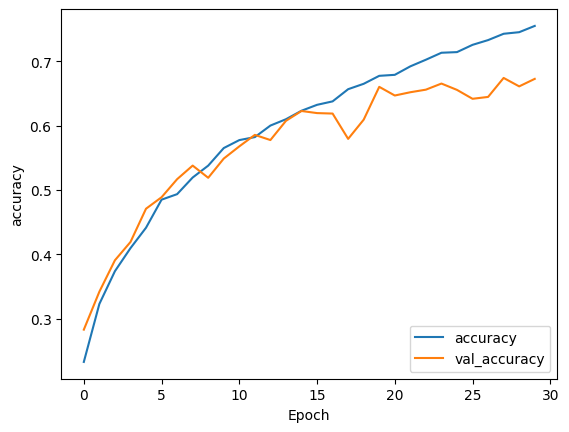

In [7]:
def plot_accuracy_curve(training_result, metric):
    val_metric = f"val_{metric}"
    train_perf = training_result.history[metric]
    validation_perf = training_result.history[val_metric]
    
    plt.plot(train_perf, label=metric)
    plt.plot(validation_perf, label=val_metric)
    
    max_val = max(validation_perf)
    max_val_epoch = validation_perf.index(max_val)
    
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.legend(loc="lower right")
    
plot_accuracy_curve(history, "accuracy")

## Find the epoch at which the difference in training and validation accuracies are minimized.

In [8]:
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

acc_diff = [abs(train - val) for train, val in zip(train_acc, val_acc)]

min_diff = min(acc_diff)
min_diff_epoch = acc_diff.index(min_diff) + 1

train_acc_at_min_diff = train_acc[min_diff_epoch - 1]  
val_acc_at_min_diff = val_acc[min_diff_epoch - 1]      

print(f"Minimum difference between accuracy and validation accuracy: {min_diff:.1f} at epoch {min_diff_epoch}")
print(f"Training Accuracy at epoch {min_diff_epoch}: {train_acc_at_min_diff:.1f}")
print(f"Validation Accuracy at epoch {min_diff_epoch}: {val_acc_at_min_diff:.1f}")


Minimum difference between accuracy and validation accuracy: 0.0 at epoch 15
Training Accuracy at epoch 15: 0.6
Validation Accuracy at epoch 15: 0.6


## Evaluate the model on unseen ImageNet images.

### Prepare the evaluation ImageNet images
In the same directory as this notebook, you will find a file named `imagenet_224_eval.zip`. This zip file contains the ImageNet images used for evaluating the CNN.
Unzip the files to a folder named `imagenet_224_eval`. The unzipped files will have the following structure:

```
imagenet_224_eval
----airplane
----automobile
----...
----ship
----truck
``` 
If the folder structure doesn't match this, then you will get an error!

In [9]:
UNSEEN_IMAGENET_IMG_DIR = os.path.join(os.getcwd(), "imagenet_224_eval")

if not os.path.exists(UNSEEN_IMAGENET_IMG_DIR):
    raise RuntimeError(
        f"{UNSEEN_IMAGENET_IMG_DIR} not found. You need to download the ImageNet evaluation dataset and unzip it into a folder called imagenet_224_eval")

eval_imagenet_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    UNSEEN_IMAGENET_IMG_DIR,          
    image_size=TARGET_SIZE,      
    batch_size=BATCH_SIZE             
)

# Prefetch for better performance.
eval_imagenet_dataset = eval_imagenet_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

loss, accuracy = model.evaluate(eval_imagenet_dataset)

print(f"Loss on unseen ImageNet images: {loss:.1f}")
print(f"Accuracy on unseen ImageNet images: {accuracy:.1f}")

Found 1000 files belonging to 10 classes.
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.6766 - loss: 1.0139
Loss on unseen ImageNet images: 0.9
Accuracy on unseen ImageNet images: 0.7


## Evaluate the model on CIFAR-10 images.

### Prepare the evaluation CIFAR-10 images
In the same directory as this notebook, you will find a file named `cifar-10.zip`. This zip file contains the ImageNet images used for evaluating the CNN against a totally different dataset - CIFAR-10.
Unzip the files to a folder named `cifar-10`. The unzipped files will have the following structure:

```
cifar-10
----airplane
----automobile
----...
----ship
----truck
``` 
If the folder structure doesn't match this, then you will get an error!

In [10]:
CIFAR10_IMG_DIR = os.path.join(os.getcwd(), "cifar-10")

if not os.path.exists(CIFAR10_IMG_DIR):
    raise RuntimeError(
        f"{CIFAR10_IMG_DIR} not found. You need to download the CIFAR-10 dataset and unzip it into a folder called cifar-10")

eval_cifar_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    CIFAR10_IMG_DIR,           
    image_size=TARGET_SIZE,      
    batch_size=BATCH_SIZE              
)

# Prefetch for better performance.
eval_cifar_dataset = eval_cifar_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

loss, accuracy = model.evaluate(eval_cifar_dataset)

print(f"Loss on CIFAR-10 images: {loss:.1f}")
print(f"Accuracy CIFAR-10 images: {accuracy:.1f}")

Found 10000 files belonging to 10 classes.
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.1647 - loss: 4.2748
Loss on CIFAR-10 images: 4.3
Accuracy CIFAR-10 images: 0.2
